# Practice 6
First, lets load everything:

In [21]:
from my_functionsa import load_files, compute_biometric_scores, who_is_in, get_all_metrics
import numpy as np
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCAc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [22]:
people, people_embeddings = load_files(csv_file="people.csv", npy_file="people_embeddings.npy")
connections, connection_embeddings = load_files(csv_file="connections.csv", npy_file="connections_embeddings.npy")
print(connection_embeddings.shape, people_embeddings.shape)
connections.head()

(30000, 256) (100, 256)


,logins,passwords,ips,dates,true_attempt
0,rosemary_dahlia@email.com,11051983,77.21291.43.60,05:07:34 16-04-2023,False
1,erika_hannah@email.com,Er1k@1952,23.38787.131.178,11:20:05 23-06-2019,False
2,shaina_jaliyah@email.com,27041973,162.30849.129.34,02:40:27 23-02-2021,False
3,hindy_matthias@email.com,123456,170.8465.17.215,08:10:58 05-09-2019,False
4,paige_bonnie@email.com,PBONN1&97,165.21980.220.91,21:03:16 24-02-2022,False


In [23]:
# Here I'm randomly selecting some of the connections, to make the program faster
indexes = np.arange(len(connections))
np.random.shuffle(indexes)
indexes_to_keep = indexes[:5000]
connections, connection_embeddings = connections.iloc[indexes_to_keep], connection_embeddings[indexes_to_keep]
print(connection_embeddings.shape)
connections=connections.reset_index(drop=True) #just to make sure the indexes are matching the new length of the embeddings list

(5000, 256)


## Projecting the connection embeddings:

In [24]:
print(connection_embeddings.shape, people_embeddings.shape)
all_embeddings = np.concatenate((people_embeddings, connection_embeddings)) #put all embeddings together
print(all_embeddings.shape)

projected_embeddings = TSNE(n_components=2).fit_transform(all_embeddings) #use our projection function, here TSNE
print(projected_embeddings.shape)


people_embeddings, connection_embeddings = projected_embeddings[:100], projected_embeddings[100:] #separate back the embeddings
print(connection_embeddings.shape, people_embeddings.shape)

(5000, 256) (100, 256)
(5100, 256)
(5100, 2)
(5000, 2) (100, 2)


## Recompute the scores

In [25]:
connections['scores'] = compute_biometric_scores(people, people_embeddings, 
                                                  connections, connection_embeddings,
                                                  mode='only_compare_same_logins', 
                                                  distance_fct=np.linalg.norm)

## Scatterplot of the projected embeddings
All in one:
- Scatter plot of the embeddings by login
- Scatter plot of the embeddings of true/false attempts
- Scores histogram

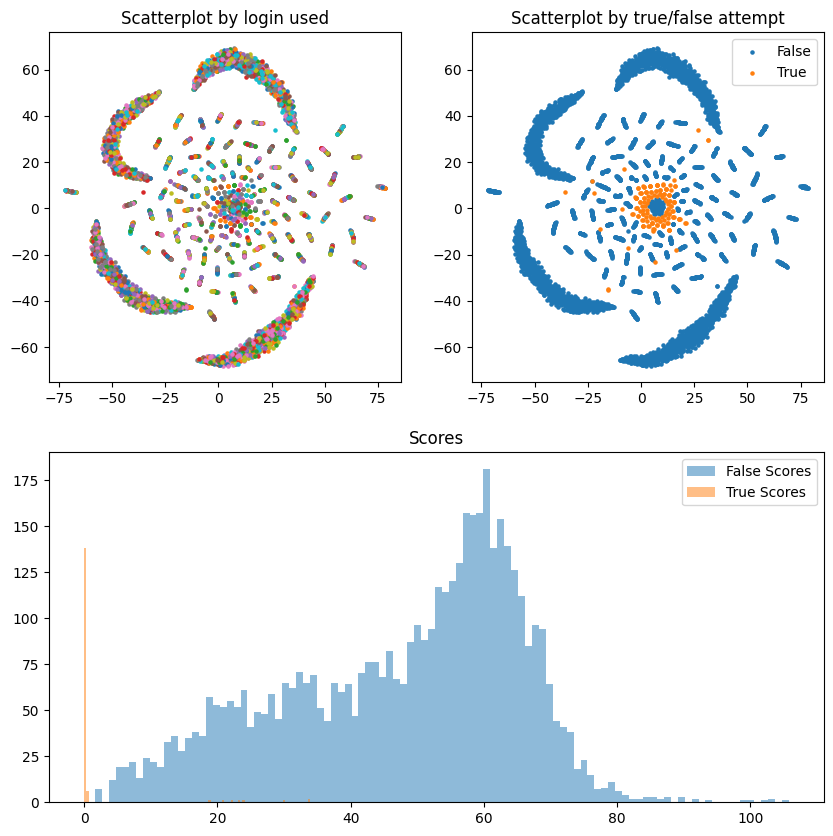

In [26]:
fig = plt.figure(figsize=(10,10))

X = connection_embeddings[:,0]
Y = connection_embeddings[:,1]

labels = np.array(connections['logins'])
true_attempt = np.array(connections['true_attempt'])
size=5

ax_1 = plt.subplot(221) #First plot
for i in set(labels):
    ax_1.scatter(X[labels==i], Y[labels==i], label=i, s=size)
ax_1.set_title("Scatterplot by login used")
    
ax_2 = plt.subplot(222) #Second plot
ax_2.scatter(X[true_attempt==False], Y[true_attempt==False], label='False', s=size)
ax_2.scatter(X[true_attempt], Y[true_attempt], label='True', s=size)
ax_2.set_title("Scatterplot by true/false attempt")
ax_2.legend()


ax_3 = plt.subplot(212)#third plot
true_scores = list(connections[connections['true_attempt']==True]['scores'])
false_scores = list(connections[connections['true_attempt']==False]['scores'])
ax_3.hist(false_scores, label='False Scores', bins=100, alpha=0.5)
ax_3.hist(true_scores,  label='True Scores',  bins=100, alpha=0.5)
ax_3.set_title("Scores")
ax_3.legend()

plt.show()

## Results
How is that impacting the scores and the authentication results?

In [34]:

accepted = who_is_in(people, connections, threshold=0.129)
get_all_metrics(accepted, 
                list(connections['true_attempt']), 
                print_output=True,
                save_output=False,
                log_file='output_week5.log')




TAR: 100.0
FAR: 0.0
TRR: 99.3849938499385
FRR: 0.6150061500615006
Accuracy: 99.4



Now you can add the results you obtain to this table:

|   System   |   Threshold   |   FAR   |   FRR   |   Accuracy   |
| ---------- | ------------- | ------- | ------- | ------------ |
| 256 dim embeddings | 25 | 0 | 0.705 | 99.32 |
| TSNE | 1.31 |  0.666 | 0.1855  | 99.8%  |
| PCA  |  0.1 |  0.00 | 0.79  |  99.2 |
| LDA  |   |   |   |   |
